In [98]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [99]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **NVL DATA PREPARATION**

In [100]:
# Read Data
df = pd.read_csv('NVL Historical Data 1_6 Fed.csv')

In [101]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'NVL'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,NVL,2018-01-02,27815.0
1,NVL,2018-01-03,28410.0
2,NVL,2018-01-04,28707.0
3,NVL,2018-01-05,28962.0
4,NVL,2018-01-06,28473.5
...,...,...,...
2338,NVL,2024-05-28,14500.0
2339,NVL,2024-05-29,14150.0
2340,NVL,2024-05-30,14150.0
2341,NVL,2024-05-31,14450.0


In [102]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [103]:
# Sizing
size = int(len(df1))

# 9 : 1 Ratio
train_data = df1[:int(0.9 *size)]
test_data = df1[int(0.9 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 2108
Test lenght: 235


In [104]:
# Train_data MAX Value
train_data.max()

unique_id                    NVL
ds           2023-10-10 00:00:00
y                        92366.0
dtype: object

# **TRAINING PROCESSS**

In [105]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 100,  # 100 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [106]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 251 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
655 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [107]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [108]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [109]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [110]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [111]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
235    16124.386719
236    15917.858398
237    15608.773438
238    16008.374023
239    15563.063477
240    16007.331055
241    16027.613281
242    15902.048828
243    15712.195312
244    15883.875977
245    15231.263672
246    15199.864258
247    15428.090820
248    15642.264648
249    15356.748047
250    15168.018555
251    14710.349609
252    14851.730469
253    15519.196289
254    15275.417969
255    15797.809570
256    15521.678711
257    15666.349609
258    15239.946289
259    15238.052734
260    15412.275391
261    15193.040039
262    15524.775391
263    15729.359375
264    15229.573242
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
265    15388.356445
266    15788.350586
267    15456.694336
268    15656.068359
269    16352.974609
270    16209.413086
271    15903.180664
272    15689.945312
273    15339.533203
274    15365.534180
275    15102.413086
276    15064.248047
277    14300.036133
278    13900.335938
279    14111

# **EVALUATION**

In [112]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1196.2883325022162
Mean Absolute Percentage Error (MAPE): 0.07551581607110207
Mean Square Error (MSE): 2037904.3642275117
Root Mean Square Error (RMSE): 1427.5518779461263


# **VISUALIZATION**

In [113]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

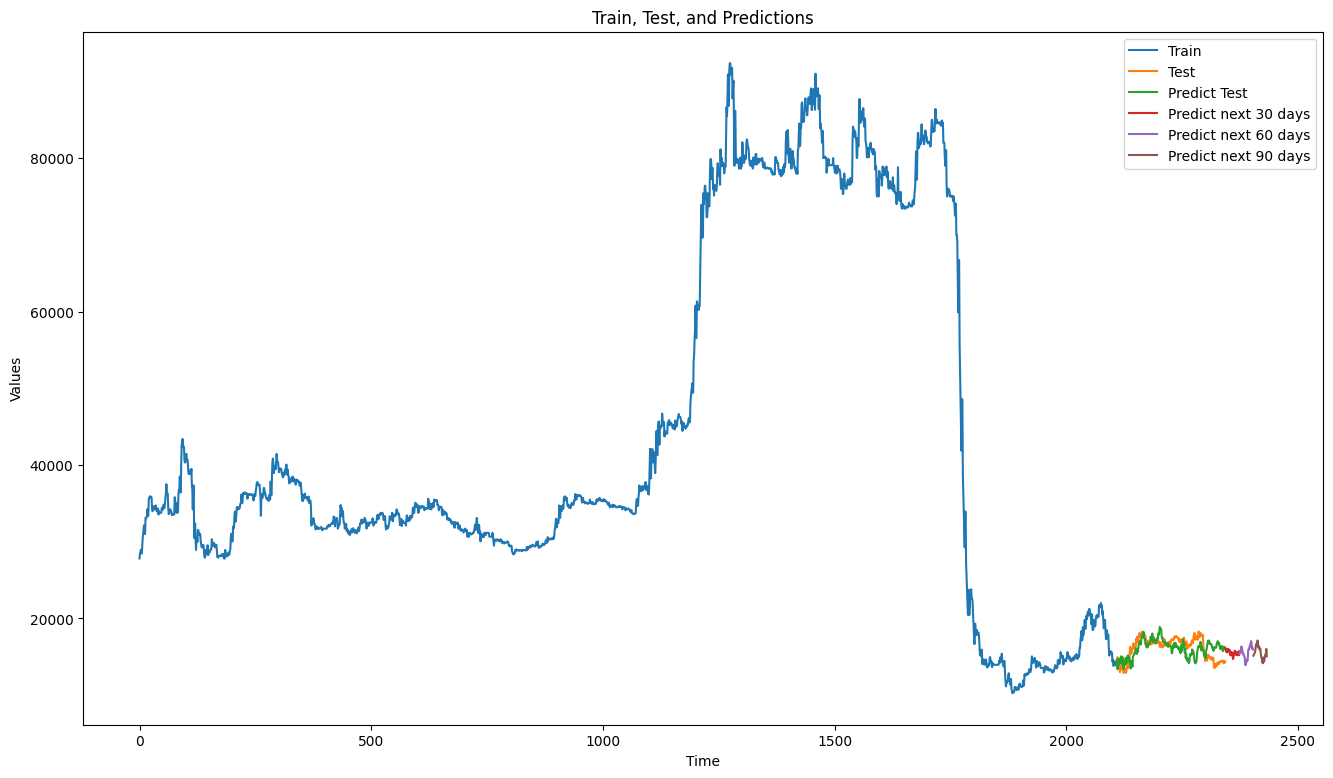

In [114]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [115]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [116]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [117]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [118]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[15947.639 15943.819 15937.016 15887.627 15831.46  15747.023 15690.776
 15642.558 15623.103 15595.5   15537.907 15495.391 15442.379 15406.905
 15386.795 15368.577 15342.672 15332.727 15303.152 15271.958 15242.558
 15262.21  15305.314 15366.546 15419.912 15495.575 15536.894 15598.26
 15667.875 15718.714]

Predicted Data for the next 60 days:
[15729.082 15703.563 15649.951 15565.951 15460.003 15353.073 15286.409
 15202.531 15149.576 15077.955 15010.975 14983.406 14994.686 15022.466
 15082.353 15155.766 15222.975 15296.348 15349.952 15402.701 15476.714
 15552.194 15633.967 15731.725 15803.01  15928.73  16047.247 16149.343
 16223.598 16258.041]

Predicted Data for the next 90 days:
[16267.336  16289.507  16312.901  16290.578  16270.728  16268.519
 16245.331  16164.2295 16118.379  16048.368  15969.819  15906.828
 15850.524  15737.183  15685.566  15512.049  15340.299  15175.747
 15023.83   14889.979  14779.627  14698.209  14651.158  14643.908
 14681.892 

# **RE - EVALUATION**

In [119]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1167.8452183067375
Mean Absolute Percentage Error (MAPE): 0.07365512176245374
Mean Square Error (MSE): 1829825.46144645
Root Mean Square Error (RMSE): 1352.7104130028904


# **RE - VISUALIZATION**

In [120]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

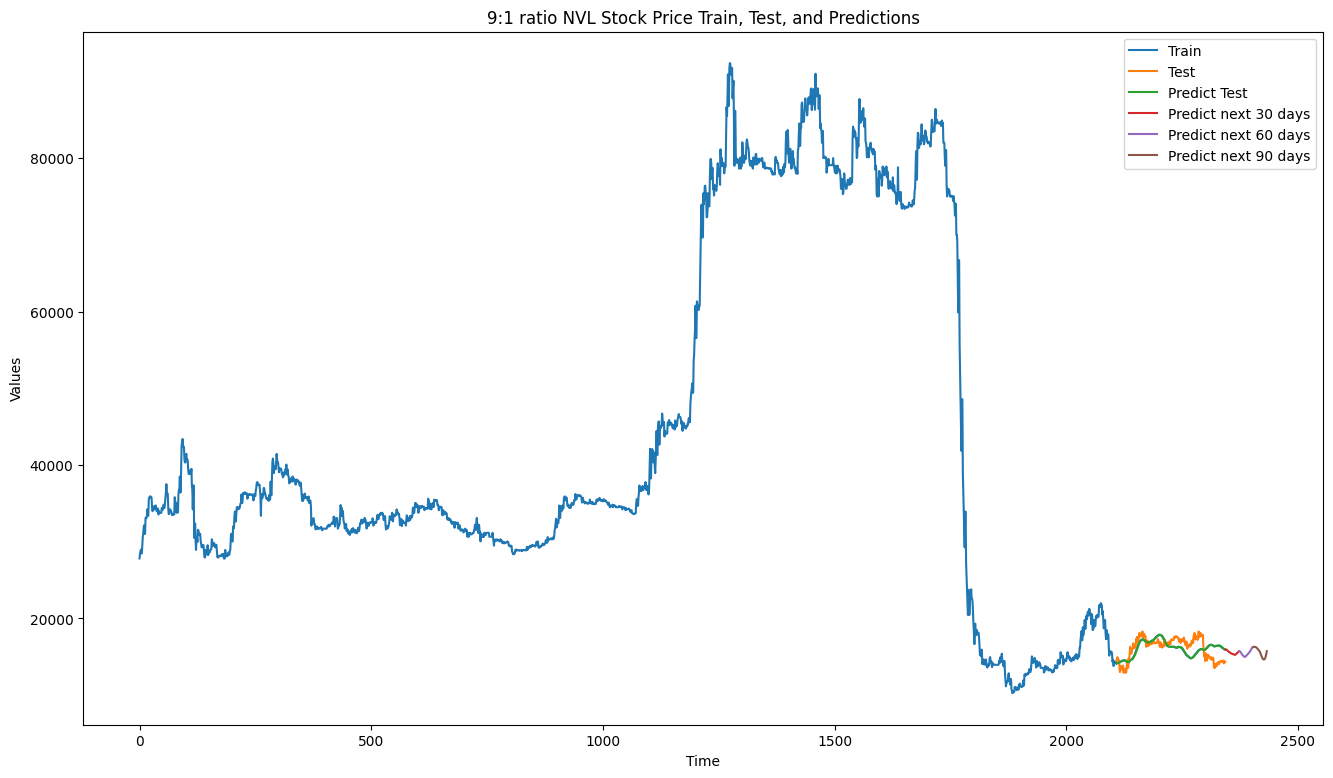

In [121]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('9:1 ratio NVL Stock Price Train, Test, and Predictions')
plt.show()